## Tensor Contraction to Solve multivariate polynomials

First going to solve the polynomial 
$$h(x,y,z) = f_1(x) + g_1(y) + l_1(z)$$

This will take the form of a tensor contraction as such...I'll eventually right what all these indices are but for now refer to the paper.

$$F_{x\alpha}G_{y\beta}\oplus_{\alpha\beta\gamma}L_{z\alpha^\prime}\oplus_{\gamma \alpha^\prime\gamma^\prime}$$
$$= H_{xy\gamma}L_{z\alpha^\prime}\oplus_{\gamma \alpha^\prime\gamma^\prime}$$
$$= H_{xyz,\gamma^\prime}$$

In [1]:
import numpy as np

In [7]:
def f(x):
    return x*x

def g(y):
    return np.exp(-y)

def l(z):
    
    return np.sin(z)

In [8]:
dt = 0.01
x = np.arange(0,3,dt)
dx = dt*np.ones(len(x))
dx[0] = 0.5*dt
dx[-1] = 0.5*dt

y = np.arange(-1,1,dt)
dy = dt*np.ones(len(y))
dimy = int(len(dy)/2)
dy[0] = 0.5*dt
dy[-1] = 0.5*dt

z = np.arange(-1*np.pi, np.pi, dt)
dz = dt*np.ones(len(z))
dz[0] = 0.5*dt
dz[-1] = 0.5*dt

In [9]:
F = np.ones((len(x), 2))
F[:,0] = dt
F[:,1] = [ f(x[i])*dx[i] for i in range(len(x))]

G = np.ones((len(y), 2))
G[:,0] = dt
G[:,1] = [ g(y[i])*dy[i] for i in range(len(y))]

L = np.ones((len(z), 2))
L[:,0] = dt
L[:,1] = [ l(z[i])*dz[i] for i in range(len(z))]
print(np.shape(L))
print(L[0:10,0])

(629, 2)
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [10]:
add = np.zeros((2,2,2))
mult = np.zeros((2,2,2))
ita = np.nditer(add, flags=['multi_index'])
itb = np.nditer(mult, flags=['multi_index'])

#### Tensor for addition
for j in ita:
    alpha = ita.multi_index[0]
    beta = ita.multi_index[1]
    gamma = ita.multi_index[2]
    if  (alpha + beta) == gamma:
        add[alpha,beta,gamma] = 1
#### Tensor for multiplication
for j in itb:
    alpha = itb.multi_index[0]
    beta = itb.multi_index[1]
    gamma = itb.multi_index[2]
    if alpha == beta == gamma:
        mult[alpha,beta,gamma] =1

In [11]:
from scipy.integrate import trapezoid, simpson, quad, nquad

func = lambda x,y,z: f(x) + g(y) + l(z)
print(nquad(func,[[0,3],[-1,1],[-np.pi,np.pi]]))
print(quad(g,-1,1))
print(trapezoid(g(y),dx=dt))

(157.40137676652841, 1.7475063259389901e-12)
(2.350402387287603, 2.6094708475006315e-14)
2.3467246932805503


In [103]:
H1 = np.einsum('xa, yb, abg -> xyg',F,G,add)
H2 = np.einsum('xya,zb, abg ->xyzg',H1,L,add)
inth = np.einsum('xyza -> a',H2)
print(inth)

[ 37.74       156.37486123]


## Now with a Tensor Network

In [2]:
import quimb as qu
import quimb.tensor as qtn

/Users/mekenametcalf/miniforge3/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/mekenametcalf/miniforge3/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/mekenametcalf/miniforge3/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [23]:
ftn = qtn.Tensor(F,inds=('x','a'),tags=('F'))
gtn = qtn.Tensor(G,inds=('y','b'),tags=('G'))
ltn = qtn.Tensor(L,inds=('z','ap'),tags=('L'))
atn1 = qtn.Tensor(add,inds=('a','b','g'),tags=('S'))
atn2 = qtn.Tensor(add,inds=('g','ap','gp'),tags=('S'))

In [24]:
TN = ftn & gtn & ltn & atn1 & atn2
# TN = ftn & gtn & atn1

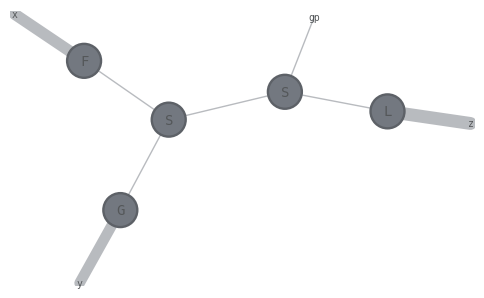

In [25]:
TN.draw()

In [26]:
a = TN ^ ...

In [28]:
data = a.data
print(np.einsum('xyza -> a',data))

[ 37.74       156.37486123]


## Multiplication

$$ h(x,y) = (f_1(x) + g_1(y))(f_2(x) + g_2(y))$$

We can break this apart to define the tensor network


In [3]:
def f1(x):
    
    return x**2 # *x

def g1(y):
    
    return y #np.exp(-y)

def f2(x):
    
    return np.sin(x)

def g2(y):
    
    return np.cos(y)

In [4]:
dt = 0.01

x = np.arange(0,3,dt)
dx = dt*np.ones(len(x))
dx[0] = 0.5*dx[0]
dx[-1] = 0.5*dx[-1]

y = np.arange(-1*np.pi,np.pi,dt)
dy = dt*np.ones(len(y))
dy[0] = 0.5*dy[0]
dy[-1] = 0.5*dy[-1]

In [5]:
F1 = np.ones((len(x), 2))
F1[:,0] = dt
F1[:,1] = [ f1(x[i])*dx[i] for i in range(len(x))]

G1 = np.ones((len(y), 2))
G1[:,0] = 1
G1[:,1] = [ g1(y[i])*dy[i] for i in range(len(y))]

F2 = np.ones((len(x), 2))
F2[:,0] = dt
F2[:,1] = [ f2(x[i])*dx[i] for i in range(len(x))]

G2 = np.ones((len(y), 2))
G2[:,0] = 1
G2[:,1] = [ g2(y[i])*dy[i] for i in range(len(y))]

In [161]:
func = lambda x,y: (f2(x) + g2(y)) *(f1(x) + g1(y))
print(nquad(func,[[0,3],[-np.pi,np.pi]]))

(36.29587251479145, 4.863437186678866e-13)


In [12]:
H1 = np.einsum('xa, yb, abg -> xyg',F1,G1,add)
H2 = np.einsum('xa,yb, abg ->xyg',F2,G2,add)
H3 = np.einsum('xya, xyb, abg -> xyg',H1, H2, mult)
print(np.shape(H3))
inth = np.einsum('xya -> a',H3)
print(inth)

(300, 629, 2)
[18.87      36.2312705]


In [13]:
f1tn = qtn.Tensor(F1,inds=('x','a'),tags=('F1'))
g1tn = qtn.Tensor(G1,inds=('y','b'),tags=('G1'))
f2tn = qtn.Tensor(F2,inds=('x','ap'),tags=('F1'))
g2tn = qtn.Tensor(G2,inds=('y','bp'),tags=('G1'))

atn1 = qtn.Tensor(add,inds=('a','b','g'),tags=('S1'))
atn2 = qtn.Tensor(add,inds=('ap','bp','gp'),tags=('S2'))
mtn = qtn.Tensor(mult,inds=('g','gp','u'),tags=('M'))

In [14]:
TN1 = f1tn & g1tn & atn1 & f2tn & g2tn & atn2  & mtn


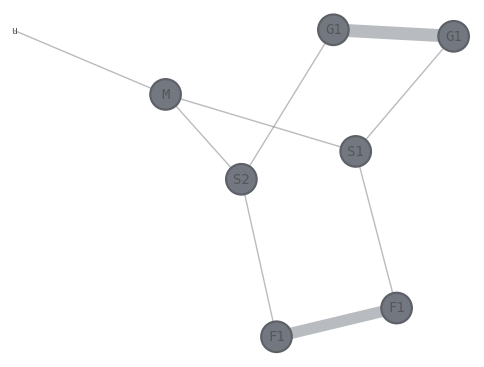

In [16]:
TN1.draw()

In [21]:
out = TN1 ^ ...
print(out.data)

[18.87      36.2312705]


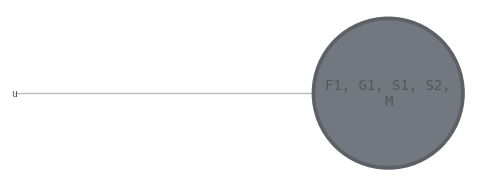

In [19]:
out.draw()

## Testing Quimb issues

In [144]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

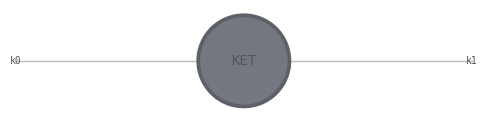

In [145]:
ket.draw()



In [146]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])

In [147]:
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])

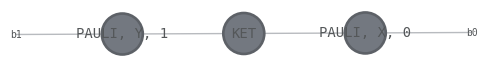

In [150]:
TN = ket.H & X & Y #& bra
TN.draw()

In [151]:
TN ^ ...

Tensor(shape=(2, 2), inds=('b0', 'b1'), tags=oset(['KET', 'PAULI', 'X', '0', 'Y', '1']))